

# 1. Importing tools



In [1]:
!pip install torch torchvision torchaudio pandas numpy scikit-learn matplotlib

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# 2. Load the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
df = pd.read_csv('/content/drive/MyDrive/mergebrain.csv')

print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (46700, 7)
   channel_1  channel_2  channel_3  channel_4   beta_power  focus_score  \
0  52.762509  52.111766  23.783894  36.593986     0.000000       0.0000   
1  22.416025  34.874567  25.187291   8.590550     0.000000       0.0000   
2  20.846202  38.616337  58.289146  25.274244     0.000000       0.0000   
3  22.962986  17.306387  33.834875  35.463601     0.000000       0.0000   
4  30.205302   9.085152  21.168769  30.477380  1776.640052       0.0925   

   focused_classification  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  


In [22]:
import numpy as np

# Parameters
n_channels = 4
window_size = 250  # 1s at 250Hz
step_size = 125    # 50% overlap

# Extract arrays
data = df[['channel_1', 'channel_2', 'channel_3', 'channel_4']].values
labels = df['focused_classification'].values

# ---- SPLIT BEFORE WINDOWING ----
split_point = int(len(data) * 0.8)  # 80% train, 20% val
train_data, val_data = data[:split_point], data[split_point:]
train_labels, val_labels = labels[:split_point], labels[split_point:]

# ---- DEFINE WINDOWING FUNCTION ----
def make_windows(data, labels, window_size=250, step_size=125):
    X, y = [], []
    for start in range(0, len(data) - window_size, step_size):
        end = start + window_size
        X.append(data[start:end].T)  # shape (4, window)
        y.append(int(labels[start:end].mean() > 0.5))  # majority label
    return np.array(X), np.array(y)

# ---- WINDOW EACH SET SEPARATELY ----
X_train, y_train = make_windows(train_data, train_labels, window_size, step_size)
X_val, y_val = make_windows(val_data, val_labels, window_size, step_size)

# ---- OPTIONAL AUGMENTATION (ONLY ON TRAIN) ----
def augment(X, noise_std=0.01):
    return X + np.random.randn(*X.shape) * noise_std

X_aug = augment(X_train)
X_train = np.concatenate([X_train, X_aug])
y_train = np.concatenate([y_train, y_train])

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)


Train: (594, 4, 250) (594,)
Val: (73, 4, 250) (73,)


# 3. Preprocessing the dataset

In [44]:
scaler = StandardScaler()

# Ensure numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)

# Remove extra dimension only if it exists
if X_train.ndim == 4:  # e.g. (N, 1, 4, 250)
    X_train = X_train.squeeze(1)
    X_val = X_val.squeeze(1)

print("After squeeze (if any):", X_train.shape, X_val.shape)

# Now reshape to (samples * time, channels)
X_train_reshaped = X_train.transpose(0, 2, 1).reshape(-1, n_channels)
X_val_reshaped   = X_val.transpose(0, 2, 1).reshape(-1, n_channels)

# Fit and transform
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled   = scaler.transform(X_val_reshaped)

# Reshape back
X_train = X_train_scaled.reshape(-1, window_size, n_channels).transpose(0, 2, 1)
X_val   = X_val_scaled.reshape(-1, window_size, n_channels).transpose(0, 2, 1)

# Save scaler
joblib.dump(scaler, "scaler.pkl")

After squeeze (if any): (595, 4, 250) (149, 4, 250)


['scaler.pkl']

In [45]:
# Convert NumPy arrays to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze().unsqueeze(1) # Added .squeeze()
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).squeeze().unsqueeze(1)   # Added .squeeze()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


/tmp/ipython-input-1041057191.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).squeeze().unsqueeze(1) # Added .squeeze()
/tmp/ipython-input-1041057191.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32).squeeze().unsqueeze(1)   # Added .squeeze()


# 4. Defining CNN model

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class EEGNet(nn.Module):
    def __init__(self, n_channels=4, n_timepoints=250):
        super(EEGNet, self).__init__()
        self.n_channels = n_channels
        self.n_timepoints = n_timepoints

        # Temporal Convolution
        self.conv1 = nn.Conv2d(1, 16, (1, 64), padding=(0, 32), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(16)

        # Depthwise Convolution
        self.depthwise = nn.Conv2d(16, 32, (n_channels, 1), groups=16, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pooling2 = nn.AvgPool2d((1, 4))
        self.dropout2 = nn.Dropout(0.5)

        # Separable Convolution
        self.separable = nn.Conv2d(32, 32, (1, 16), padding=(0, 8), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(32)
        self.pooling3 = nn.AvgPool2d((1, 8))
        self.dropout3 = nn.Dropout(0.5)

        # Fully Connected (output)
        # This depends on timepoints and pooling size
        self.output_size = self._get_output_size()
        self.fc1 = nn.Linear(self.output_size, 1)

    def _get_output_size(self):
        # Simulate forward pass to compute flattened size
        x = torch.zeros(1, 1, self.n_channels, self.n_timepoints)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.elu(x)
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = F.elu(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        x = self.separable(x)
        x = self.batchnorm3(x)
        x = F.elu(x)
        x = self.pooling3(x)
        x = self.dropout3(x)
        return x.view(1, -1).shape[1]

    def forward(self, x):
        x = F.elu(self.batchnorm1(self.conv1(x)))
        x = F.elu(self.batchnorm2(self.depthwise(x)))
        x = self.pooling2(x)
        x = self.dropout2(x)
        x = F.elu(self.batchnorm3(self.separable(x)))
        x = self.pooling3(x)
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        return x


In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGNet(n_channels=4, n_timepoints=250).to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 5. Training Loop

In [47]:
EPOCHS = 30
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        # Add a pseudo-channel dimension for EEGNet
        Xb = Xb.unsqueeze(1)
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            # Add a pseudo-channel dimension for EEGNet
            Xb = Xb.unsqueeze(1)
            preds = model(Xb)
            val_loss += criterion(preds, yb).item()
            predicted_labels = (preds > 0.5).float()
            correct += (predicted_labels == yb).sum().item()

    acc = correct / len(X_val)
    train_losses.append(total_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{EPOCHS}: Train {train_losses[-1]:.4f}, Val {val_losses[-1]:.4f}, Acc {acc:.2%}")

Epoch 1/30: Train 0.3630, Val 0.2500, Acc 92.62%
Epoch 2/30: Train 0.1896, Val 0.1514, Acc 94.63%
Epoch 3/30: Train 0.1500, Val 0.1103, Acc 94.63%
Epoch 4/30: Train 0.1354, Val 0.0996, Acc 97.32%
Epoch 5/30: Train 0.1451, Val 0.0971, Acc 97.32%
Epoch 6/30: Train 0.1403, Val 0.0772, Acc 97.32%
Epoch 7/30: Train 0.1456, Val 0.0858, Acc 97.99%
Epoch 8/30: Train 0.1204, Val 0.0765, Acc 97.32%
Epoch 9/30: Train 0.1286, Val 0.0976, Acc 97.99%
Epoch 10/30: Train 0.1135, Val 0.0758, Acc 97.32%
Epoch 11/30: Train 0.1195, Val 0.0662, Acc 97.32%
Epoch 12/30: Train 0.1034, Val 0.0714, Acc 97.32%
Epoch 13/30: Train 0.1014, Val 0.0619, Acc 97.32%
Epoch 14/30: Train 0.1251, Val 0.0582, Acc 95.97%
Epoch 15/30: Train 0.1291, Val 0.0627, Acc 97.99%
Epoch 16/30: Train 0.1085, Val 0.0554, Acc 97.32%
Epoch 17/30: Train 0.1013, Val 0.0620, Acc 97.32%
Epoch 18/30: Train 0.0998, Val 0.0508, Acc 97.32%
Epoch 19/30: Train 0.0791, Val 0.0493, Acc 97.32%
Epoch 20/30: Train 0.0871, Val 0.0461, Acc 97.99%
Epoch 21/

# 6. Plotting graphs

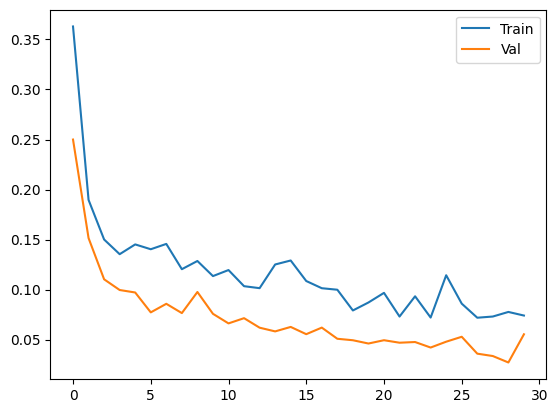

In [48]:
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.legend()
plt.show()

In [50]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculations
    # Use X_val_tensor and add the pseudo-channel dimension
    y_pred = model(X_val_tensor.to(device).unsqueeze(1)) # Get predictions for the entire validation set

# Move predictions and true labels to CPU for sklearn functions
y_pred_cpu = y_pred.cpu().numpy()
y_val_cpu = y_val_tensor.cpu().numpy() # Use y_val_tensor for consistency

preds = (y_pred_cpu > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_val_cpu, preds))
print("\nClassification Report:")
print(classification_report(y_val_cpu, preds))

Confusion Matrix:
[[109   0]
 [  3  37]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       109
         1.0       1.00      0.93      0.96        40

    accuracy                           0.98       149
   macro avg       0.99      0.96      0.97       149
weighted avg       0.98      0.98      0.98       149



# 7. Saving the model

In [51]:
torch.save(model.state_dict(), "focus_eegnet_4ch.pth")
print("Model saved as focus_eegnet_4ch.pth")

Model saved as focus_eegnet_4ch.pth


In [52]:
from google.colab import files
files.download("focus_eegnet_4ch.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>